In [201]:
import datetime
import geopandas
import importlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
from pathlib import Path
import rasterio
from rasterio.plot import show as rio_show
import xarray as xr

import moad_tools.midoss.random_oil_spills as ros

%matplotlib inline

In [2]:
importlib.reload(ros)

<module 'moad_tools.midoss.random_oil_spills' from '/Users/sallen/Documents/MIDOSS/moad_tools/moad_tools/midoss/random_oil_spills.py'>

In [3]:
random_seed = 101
random_generator = numpy.random.default_rng(random_seed)

In [4]:
geotiffs_dir = Path('/Users/sallen/Documents/MIDOSS/ShipTrackDensityGeoTIFFs/')
spill_date_hour = datetime.datetime(2015, 9, 11, 13)
dataset = rasterio.open(geotiffs_dir / f"all_2018_{spill_date_hour.month:02.0f}.tif")

In [5]:
mesh = xr.open_dataset('/Users/sallen/Documents/MEOPAR/grid/mesh_mask201702.nc')

In [6]:
watermask = numpy.load('gifmesh.npy')

In [7]:
lat, lon, x_index, y_index, llx, lly, urx, ury, data_out = ros.get_lat_lon_indices(
            geotiffs_dir,
            spill_date_hour.month,
            watermask,
            mesh,
            random_generator=random_generator,
        )

In [39]:
print (lat, lon, x_index, y_index, llx, lly, urx, ury)

48.192264556884766 -123.4121576944987 281 473 -123.42134135200332 48.185361624856405 -123.40631079302298 48.200392183836755


In [9]:
shapefile_dir = Path('/Users/sallen/Documents/MIDOSS/shapefiles/')
vessel_type = 'cargo'
month = '01'
data = geopandas.read_file(shapefile_dir / 
                        f"{vessel_type}_2018_{month}" /
                        f"{vessel_type}_2018_{month}.shp")

In [52]:
data

,MMSI,ST_DATE,EN_DATE,LENGTH,TO,FROM_,geometry
0,209034000,2018-01-01 05:29:11,2018-01-01 05:29:33,229,None,None,"LINESTRING (-125.91134 48.00090, -125.90970 48..."
1,209034000,2018-01-01 05:29:33,2018-01-01 05:29:42,229,None,None,"LINESTRING (-125.90970 48.00167, -125.90898 48..."
2,209034000,2018-01-01 05:29:42,2018-01-01 05:29:52,229,None,None,"LINESTRING (-125.90898 48.00203, -125.90824 48..."
3,209034000,2018-01-01 05:29:52,2018-01-01 05:30:11,229,None,None,"LINESTRING (-125.90824 48.00238, -125.90686 48..."
4,209034000,2018-01-01 05:30:11,2018-01-01 05:30:23,229,None,None,"LINESTRING (-125.90686 48.00298, -125.90596 48..."
...,...,...,...,...,...,...,...
296977,636092766,2018-01-15 23:26:34,2018-01-15 23:28:34,207,None,None,"LINESTRING (-128.45305 48.52267, -128.46224 48..."
296978,636092766,2018-01-15 23:28:34,2018-01-15 23:29:14,207,None,None,"LINESTRING (-128.46224 48.52259, -128.46531 48..."
296979,636092766,2018-01-15 23:29:14,2018-01-15 23:29:54,207,None,None,"LINESTRING (-128.46531 48.52257, -128.46838 48..."
296980,636092766,2018-01-15 23:29:54,2018-01-15 23:30:14,207,None,None,"LINESTRING (-128.46838 48.52262, -128.46988 48..."


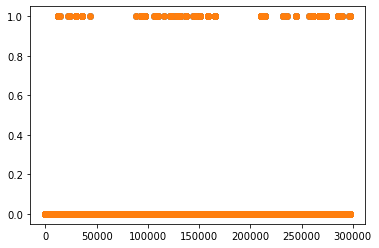

In [47]:
numberofdata = data.shape[0]
count = 0
firstin = numpy.zeros((numberofdata))
secondin = numpy.zeros_like(firstin)
for i in range(data.shape[0]):
    if (data.geometry[i].coords[0][0] < urx and 
        data.geometry[i].coords[0][0] > llx and
        data.geometry[i].coords[0][1] < ury and 
        data.geometry[i].coords[0][1] > lly):
        firstin[i] = 1
    if (data.geometry[i].coords[1][0] < urx and 
        data.geometry[i].coords[1][0] > llx and
        data.geometry[i].coords[1][1] < ury and 
        data.geometry[i].coords[1][1] > lly):
        secondin[i] = 1

In [74]:
print (firstin.sum())
print (secondin.sum())
print ((firstin*secondin).sum())
print (firstin.sum() + secondin.sum() - (firstin*secondin).sum())




157.0
159.0
116.0
200.0


In [51]:
total_seconds = numpy.zeros_like(firstin)
for index in range(numberofdata):
    if firstin[index] == 1 and secondin[index] == 1:
        start_date = datetime.datetime.strptime(data.ST_DATE[index] , 
                                       '%Y-%m-%d %H:%M:%S'
                                      )
        end_date = datetime.datetime.strptime(data.EN_DATE[index] ,
                                     '%Y-%m-%d %H:%M:%S'
                                    )
        delta_time = end_date - start_date
        total_seconds[index] = delta_time.total_seconds()
    elif firstin[index] == 1:
        print (index, 'first', data.geometry[i].coords[1])
    elif secondin[index] == 1:
        print (index, 'second', data.geometry[i].coords[0])

12532 second (-128.46987666666777, 48.522686666802414)
12536 first (-128.4713949999854, 48.52263166672556)
13965 second (-128.46987666666777, 48.522686666802414)
13966 first (-128.4713949999854, 48.52263166672556)
22397 second (-128.46987666666777, 48.522686666802414)
22398 first (-128.4713949999854, 48.52263166672556)
23873 second (-128.46987666666777, 48.522686666802414)
23874 first (-128.4713949999854, 48.52263166672556)
29823 second (-128.46987666666777, 48.522686666802414)
29837 first (-128.4713949999854, 48.52263166672556)
36100 second (-128.46987666666777, 48.522686666802414)
36105 first (-128.4713949999854, 48.52263166672556)
43289 second (-128.46987666666777, 48.522686666802414)
43290 first (-128.4713949999854, 48.52263166672556)
88564 second (-128.46987666666777, 48.522686666802414)
88565 first (-128.4713949999854, 48.52263166672556)
92838 second (-128.46987666666777, 48.522686666802414)
94582 second (-128.46987666666777, 48.522686666802414)
94592 first (-128.4713949999854, 4

In [97]:
from shapely.geometry import LineString, Polygon
from shapely.ops import split
from matplotlib import patches


In [171]:
fract = 0
hsx = llx*fract + urx*(1-fract)
hsy = lly*fract + ury*(1-fract)
polygon = Polygon([(llx, lly), (hsx, lly), (hsx, hsy), (llx, hsy), (llx, lly)])
geo_polygon = geopandas.GeoSeries(polygon)

POLYGON ((-123.4213413520033 48.18536162485641, -123.406310793023 48.18536162485641, -123.406310793023 48.20039218383675, -123.4213413520033 48.20039218383675, -123.4213413520033 48.18536162485641))


ImportError: The descartes package is required for plotting polygons in geopandas. You can install it using 'conda install -c conda-forge descartes' or 'pip install descartes'.

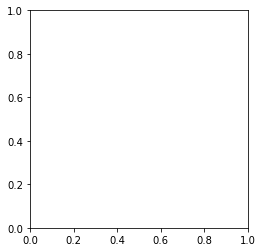

In [172]:
print(polygon)
geo_polygon.plot()

In [199]:
innerdata = geopandas.read_file(shapefile_dir / 
                        f"{vessel_type}_2018_{month}" /
                        f"{vessel_type}_2018_{month}.shp", bbox=polygon)

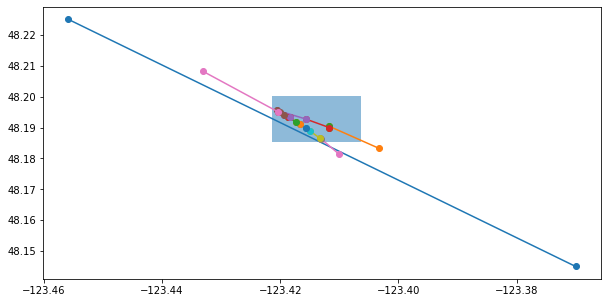

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for index in range(58, 75):
    ax.plot([innerdata.geometry[index].coords[0][0],
              innerdata.geometry[index].coords[1][0]],
             [innerdata.geometry[index].coords[0][1],
              innerdata.geometry[index].coords[1][1]], 'o-')
patch = patches.Rectangle((llx, lly), hsx-llx,  hsy-lly, alpha=0.5, axes=ax,
                         facecolor='tab:blue', fill=True)
ax.add_patch(patch);

Many tracks go right through the domain.  The example above shows all types of tracks but is not necessarily representative of the density of each type.

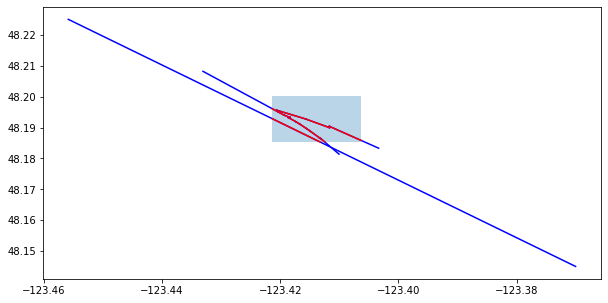

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
patch = patches.Rectangle((llx, lly), hsx-llx,  hsy-lly, alpha=0.3, axes=ax,
                         facecolor='tab:blue', fill=True)
ax.add_patch(patch);
for index in range(58, 75):
    segment = LineString([[innerdata.geometry[index].coords[0][0], 
                           innerdata.geometry[index].coords[0][1]],
                         [innerdata.geometry[index].coords[1][0],
                         innerdata.geometry[index].coords[1][1]]])
    inside = segment.intersection(polygon)
    ax.plot([innerdata.geometry[index].coords[0][0],
              innerdata.geometry[index].coords[1][0]],
             [innerdata.geometry[index].coords[0][1],
              innerdata.geometry[index].coords[1][1]], 'b-')
    ax.plot([inside.coords[0][0], inside.coords[1][0]],
             [inside.coords[0][1], inside.coords[1][1]], 'r-')
    

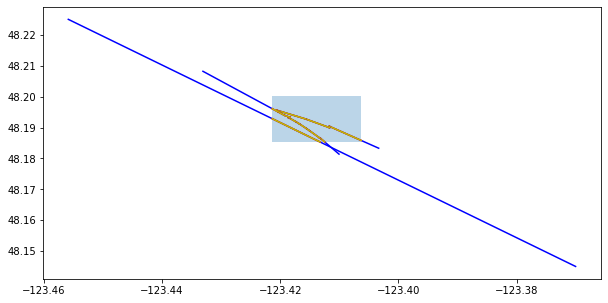

In [236]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
patch = patches.Rectangle((llx, lly), hsx-llx,  hsy-lly, alpha=0.3, axes=ax,
                         facecolor='tab:blue', fill=True)
ax.add_patch(patch);
dougs = []
for aistrack in innerdata.itertuples():
    dougs.append(aistrack.geometry.intersection(polygon))
for index in range(58, 75):
    segment = LineString([[innerdata.geometry[index].coords[0][0], 
                           innerdata.geometry[index].coords[0][1]],
                         [innerdata.geometry[index].coords[1][0],
                         innerdata.geometry[index].coords[1][1]]])
    inside = segment.intersection(polygon)
    ax.plot([innerdata.geometry[index].coords[0][0],
              innerdata.geometry[index].coords[1][0]],
             [innerdata.geometry[index].coords[0][1],
              innerdata.geometry[index].coords[1][1]], 'b-')
    ax.plot([inside.coords[0][0], inside.coords[1][0]],
             [inside.coords[0][1], inside.coords[1][1]], 'r-')
    ax.plot([dougs[index].coords[0][0], 
             dougs[index].coords[1][0]], [dougs[index].coords[0][1],
           dougs[index].coords[1][1]], 'y-')
    

In [206]:
myformat = '%Y-%m-%d %H:%M:%S'
print (abs(pd.to_datetime(innerdata.ST_DATE[58], format=myformat)- 
       pd.to_datetime(innerdata.EN_DATE[58], format=myformat)))

0 days 00:31:50


-1.3558598688234724e-14
2018-01-11 00:40:23 2018-01-11 01:12:13 0 days 00:31:50 179.58473113490473
-6.0285110237146e-14
2018-01-19 06:42:43 2018-01-19 06:45:24 0 days 00:02:41 103.55589759905904
0.0
2018-01-19 06:45:24 2018-01-19 06:45:42 0 days 00:00:18 18.0
0.0
2018-01-19 06:45:42 2018-01-19 06:46:43 0 days 00:01:01 61.0
0.0
2018-01-19 06:46:43 2018-01-19 06:48:24 0 days 00:01:41 101.0
0.0
2018-01-19 06:48:24 2018-01-19 06:48:41 0 days 00:00:17 17.0
5.162537064506978e-15
2018-01-02 16:42:54 2018-01-02 16:45:04 0 days 00:02:10 28.11035407441197
0.0
2018-01-02 16:45:04 2018-01-02 16:45:28 0 days 00:00:24 24.0
0.0
2018-01-02 16:45:28 2018-01-02 16:46:14 0 days 00:00:46 46.0
0.0
2018-01-02 16:46:14 2018-01-02 16:46:34 0 days 00:00:20 20.0
0.0
2018-01-02 16:46:34 2018-01-02 16:47:14 0 days 00:00:40 40.0
0.0
2018-01-02 16:47:14 2018-01-02 16:47:34 0 days 00:00:20 20.0
0.0
2018-01-02 16:47:34 2018-01-02 16:48:14 0 days 00:00:40 40.0
0.0
2018-01-02 16:48:14 2018-01-02 16:48:27 0 days 00:00:1

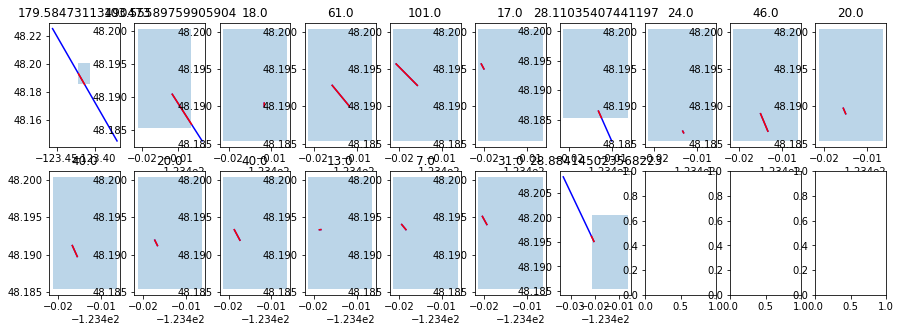

In [238]:
fig, axs = plt.subplots(2, 10, figsize=(15, 5))
for bx in range(2):
    for ax in axs[bx]:
        patch = patches.Rectangle((llx, lly), hsx-llx,  hsy-lly, alpha=0.3, axes=ax,
                         facecolor='tab:blue', fill=True)
        ax.add_patch(patch);
bx = 0
for ix, index in enumerate(range(58, 75)):
    if ix > 9:
        bx = 1
        ix = ix - 10
    segment = LineString([[innerdata.geometry[index].coords[0][0], 
                           innerdata.geometry[index].coords[0][1]],
                         [innerdata.geometry[index].coords[1][0],
                         innerdata.geometry[index].coords[1][1]]])
    inside = segment.intersection(polygon)
    axs[bx, ix].plot([innerdata.geometry[index].coords[0][0],
              innerdata.geometry[index].coords[1][0]],
             [innerdata.geometry[index].coords[0][1],
              innerdata.geometry[index].coords[1][1]], 'b-')
    axs[bx, ix].plot([inside.coords[0][0], inside.coords[1][0]],
             [inside.coords[0][1], inside.coords[1][1]], 'r-')
    ratio = ((inside.coords[1][0] - inside.coords[0][0]) /
             (innerdata.geometry[index].coords[1][0] -
              innerdata.geometry[index].coords[0][0]))
    ratio2 = inside.length/segment.length
    print (ratio - ratio2)
    vte = abs(ratio * (pd.to_datetime(innerdata.ST_DATE[index], format=myformat)- 
       pd.to_datetime(innerdata.EN_DATE[index], format=myformat)).total_seconds())
    print (pd.to_datetime(innerdata.ST_DATE[index], format=myformat), 
           pd.to_datetime(innerdata.EN_DATE[index], format=myformat), 
          abs(pd.to_datetime(innerdata.ST_DATE[index], format=myformat)- 
       pd.to_datetime(innerdata.EN_DATE[index], format=myformat)), vte)
    axs[bx, ix].set_title(f'{vte}')

In [232]:
vte = numpy.zeros(innerdata.shape[0])
for index in range(innerdata.shape[0]):
    segment = LineString([[innerdata.geometry[index].coords[0][0], 
                           innerdata.geometry[index].coords[0][1]],
                         [innerdata.geometry[index].coords[1][0],
                         innerdata.geometry[index].coords[1][1]]])
    inside = segment.intersection(polygon)
    ratio = ((inside.coords[1][0] - inside.coords[0][0]) /
             (innerdata.geometry[index].coords[1][0] -
              innerdata.geometry[index].coords[0][0]))
    vte[index] = abs(ratio * (pd.to_datetime(innerdata.ST_DATE[index], format=myformat)- 
       pd.to_datetime(innerdata.EN_DATE[index], format=myformat)).total_seconds())

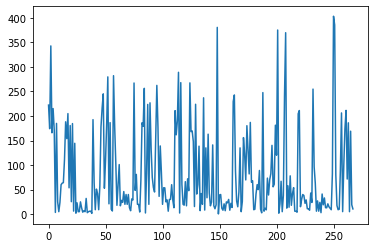

In [226]:
plt.plot(vte);

In [227]:
segment_choice = random_generator.choice(range(innerdata.shape[0]), p=vte/vte.sum())

In [233]:
print (segment_choice, innerdata.LENGTH[segment_choice], innerdata.FROM_[segment_choice],
      innerdata.TO[segment_choice], vte[segment_choice])

147 295 None None 19.0
